# 📊 Exploratory Data Analysis (EDA) - Fake News Classification - PS Ligia NLP
**Autor:** Carlos Eduardo Falcão Teixera (ceft)  
**Objetivo:** Desenvolver uma análise exploratória robusta e um pré-processamento de texto para treinar um modelo de classificação de Fake News baseado em Transformers (BERT, RoBERTa, DistilBERT).

## Contexto do Problema
O dataset utilizado contém notícias reais e falsas. Possuo a pretensão de utilizar modelos pré treinados baseado em Transformers (como BERT, RoBERTa ou DistilBERT) para esta tarefa. Em tarefas de Processamento de Linguagem Natural (NLP), modelos poderosos como Transformers são altamente suscetíveis a "aprender" os vieses e atalhos do dataset em vez da semântica real do texto (Data Leakage).

Portanto, neste notebook, o foco será:
1. Analisar e lidar com o desbalanceamento das classes.
2. Identificar e mitigar severos vazamentos de dados na estrutura do dataset.
3. Analisar a distribuição do tamanho dos textos (Word Count) para justificar os parâmetros de tokenização (`max_length`).
4. Entregar um dataset sanitizado e pronto para a modelagem.

In [5]:
# 1. Instalação e Importação de Bibliotecas
import os
import re
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from google.colab import drive

# Configuração visual padrão para gráficos
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14

print("✅ Bibliotecas importadas e ambiente configurado com sucesso.")

✅ Bibliotecas importadas e ambiente configurado com sucesso.


### 1. Carregamento dos Dados
Os dados foram salvos do [Kaggle](https://www.kaggle.com/competitions/ligia-nlp/overview) e estão sendo importados via compartilhamento do Google Drive usando a biblioteca `gdown`. Em seguida, faremos uma inspeção inicial da estrutura do DataFrame.

In [6]:
url = 'https://drive.google.com/uc?id=1lepKLR7_PWfpkafgrfGPiLRo6UFfYMEd'
output = 'train.csv'

try:
    if not os.path.exists(output):
        gdown.download(url, output, quiet=False)

    df = pd.read_csv(output)
    print("\n✅ Dataset carregado com sucesso!")
except Exception as e:
    print(f"❌ Erro ao baixar/ler o arquivo: {e}")

# Visão geral dos dados
print("\n--- Informações do DataFrame ---")
display(df.info())

print("\n--- Verificação de Valores Nulos ---")
display(df.isnull().sum())

print("\n--- Verificação de Duplicatas ---")
print(f"Linhas duplicadas: {df.duplicated().sum()}")

print("\n--- Primeiras 5 linhas ---")
display(df.head())


✅ Dataset carregado com sucesso!

--- Informações do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22844 entries, 0 to 22843
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       22844 non-null  int64 
 1   title    22844 non-null  object
 2   text     22844 non-null  object
 3   subject  22844 non-null  object
 4   date     22844 non-null  object
 5   label    22844 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


None


--- Verificação de Valores Nulos ---


,0
id,0
title,0
text,0
subject,0
date,0
label,0



--- Verificação de Duplicatas ---
Linhas duplicadas: 0

--- Primeiras 5 linhas ---


,id,title,text,subject,date,label
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 ...",WASHINGTON (Reuters) - The U.S. Department of ...,politicsNews,"January 19, 2017",0
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,HILL larious! If this was a Donald Trump pi a...,left-news,"Aug 3, 2016",1
2,27667,Philippine leader says 'no way' he'll do deal ...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"September 9, 2017",0
3,15368,Biden asks U.S. Congress to allow unencumbered...,WASHINGTON (Reuters) - Vice President Joe Bide...,politicsNews,"September 8, 2016",0
4,6934,Trump Claims ‘Any Negative Polls’ Are ‘FAKE N...,Donald Trump kicked off his Monday morning by ...,News,"February 6, 2017",1


### 2. Análise da Variável Alvo (Label)
Antes de analisar o texto, precisamos entender a distribuição das classes (0 = Real, 1 = Fake). O desbalanceamento afeta diretamente a escolha da `Loss Function` e das métricas de avaliação.

Classe 0 (Real): 17133 amostras (75.00%)
Classe 1 (Fake): 5711 amostras (25.00%)


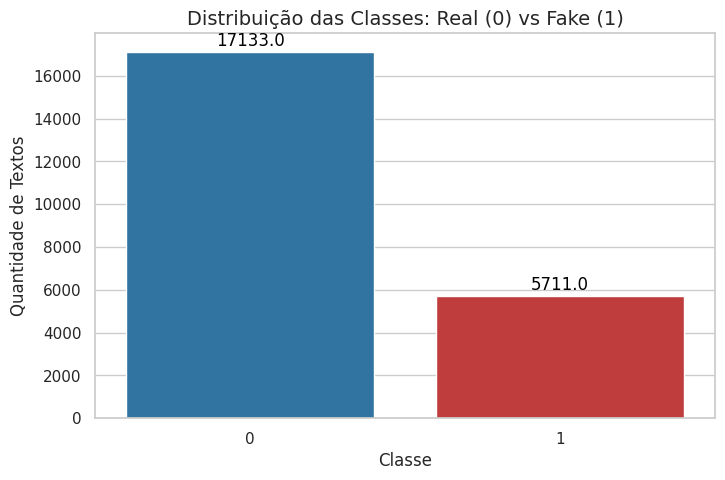

In [7]:
# Contagem de valores e proporção
label_counts = df['label'].value_counts()
label_props = df['label'].value_counts(normalize=True) * 100

print(f"Classe 0 (Real): {label_counts[0]} amostras ({label_props[0]:.2f}%)")
print(f"Classe 1 (Fake): {label_counts[1]} amostras ({label_props[1]:.2f}%)")

# Gráfico de distribuição
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='label', hue='label', palette=['#1f77b4', '#d62728'], legend=False)
plt.title("Distribuição das Classes: Real (0) vs Fake (1)")
plt.xlabel("Classe")
plt.ylabel("Quantidade de Textos")

# Adicionar os rótulos acima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.show()

**Conclusão da Análise de Classes:**
Temos um claro **desbalanceamento** de aproximadamente 3:1 em favor da classe majoritária (Real).
* **Diretriz de Modelagem:** Usaremos **F1-Score (Macro)** como medida principal e também **ROC-AUC** para auxiliar na avaliação. No treinamento do modelo Transformer, devemos aplicar parâmetros de `class_weights` na função `CrossEntropyLoss` para penalizar com maior peso os erros da classe minoritária.

### 3. Análise de Vazamento de Dados (Data Leakage) / Tratamento de dados
Vazamento de dados ocorre quando o modelo tem acesso a uma informação fora do escopo semântico do problema que resolve a classificação de forma artificial.

#### 3.1. A Coluna `subject`
Vamos investigar se o tema da notícia possui relação entre o tópico da notícia e a sua veracidade.

label,0,1,All
subject,,,
Government News,0,403,403
Middle-east,0,190,190
News,0,2206,2206
US_News,0,197,197
left-news,0,1071,1071
politics,0,1644,1644
politicsNews,9028,0,9028
worldnews,8105,0,8105
All,17133,5711,22844


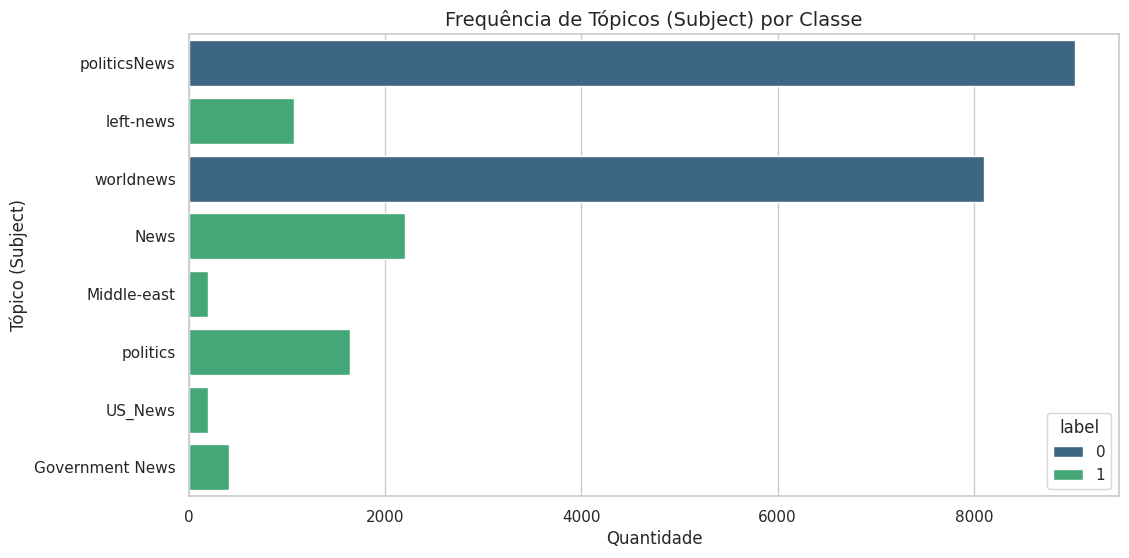

In [8]:
# Criação de uma tabela de contingência
leakage_analysis = pd.crosstab(df['subject'], df['label'], margins=True)
display(leakage_analysis)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='subject', hue='label', palette='viridis')
plt.title("Frequência de Tópicos (Subject) por Classe")
plt.xlabel("Quantidade")
plt.ylabel("Tópico (Subject)")
plt.show()

**⚠️ Alerta Crítico de Data Leakage!**
Como visto acima, a coluna `subject` funciona como um separador perfeito e determinístico (ex: 'politicsNews' é sempre classe 0, enquanto 'left-news' é sempre classe 1). Se fornecermos essa feature ao modelo, ele simplesmente criará uma regra baseada no tópico e **jamais** aprenderá o padrão linguístico da mentira.
* **Decisão:** A coluna `subject` será rigorosamente removida do dataset final.

#### 3.2. Text Leakage: A Armadilha da Agência de Notícias
Muitos datasets de Fake News construídos via extração (*scraping*) contêm marcações da agência de notícias no início das matérias verdadeiras. Vamos analisar os primeiros 50 caracteres dos textos da classe 0 (Real).

In [9]:
# Visualizar o início dos textos Reais (Classe 0)
print("--- Início de Notícias REAIS (Classe 0) ---")
display(df[df['label'] == 0]['text'].head(15).apply(lambda x: x[:80]))

print("\n--- Início de Notícias FALSAS (Classe 1) ---")
display(df[df['label'] == 1]['text'].head(15).apply(lambda x: x[:80]))

--- Início de Notícias REAIS (Classe 0) ---


,text
0,WASHINGTON (Reuters) - The U.S. Department of ...
2,MANILA (Reuters) - Philippine President Rodrig...
3,WASHINGTON (Reuters) - Vice President Joe Bide...
5,PHILADELPHIA (Reuters) - Chelsea Clinton took ...
6,NEW YORK (Reuters) - An exchange-traded fund f...
8,WASHINGTON (Reuters) - The U.S. State Departme...
9,NEW YORK/SAN FRANCISCO (Reuters) - President-...
10,GENEVA (Reuters) - U.S. President Donald Trump...
11,LIMA (Reuters) - Peruvian President Pedro Pabl...
12,MOSCOW (Reuters) - Russian President Vladimir ...



--- Início de Notícias FALSAS (Classe 1) ---


,text
1,HILL larious! If this was a Donald Trump pi a...
4,Donald Trump kicked off his Monday morning by ...
7,21st Century Wire says While everyone is busy ...
14,I thought it would be easier to carry just on...
24,"Of course, we all know that Obama is not a man..."
25,Notice how the left is still pushing the false...
29,
37,It s always the will of the people ultimately...
42,A shocking documentary reveals that at least s...
43,"21st Century Wire says Since the late 1960 s, ..."


Fica evidente que as notícias reais da base tendem a começar com o padrão `CIDADE (Reuters) - `. Isso é um **vazamento de texto**. O modelo associaria a palavra "Reuters" a "Verdade", o que é um viés indesejável.

Vamos criar uma função utilizando Expressões Regulares (Regex) para higienizar essa anomalia estrutural sem alterar o restante do texto.

In [10]:
def remove_reuters_leakage(text):
    """
    Remove o padrão inicial (ex: 'WASHINGTON (Reuters) - ')
    A busca é restrita aos primeiros 120 caracteres para evitar deletar citações genuínas no meio do texto.
    """
    # Regex: Procura do começo da string (^) até encontrar '(Reuters)' seguido de um ou mais hifens.
    return re.sub(r'^.{0,120}?\(Reuters\)\s*-\s*', '', str(text))

# Aplicando a limpeza
df['text_clean'] = df['text'].apply(remove_reuters_leakage)

# Verificação pós-limpeza
print("--- Exemplo Pós-Limpeza (Classe 0) ---")
display(df[df['label'] == 0]['text_clean'].head(5).apply(lambda x: x[:80]))

--- Exemplo Pós-Limpeza (Classe 0) ---


,text_clean
0,The U.S. Department of Defense and Lockheed Ma...
2,Philippine President Rodrigo Duterte on Saturd...
3,Vice President Joe Biden on Thursday called on...
5,Chelsea Clinton took the stage of the Democrat...
6,An exchange-traded fund focused on Mexico has ...


#### 3.3. Tratamento de Textos Vazios (Falsos Não-Nulos)
A etapa de `df.isnull().sum()` indicou que não havia valores nulos. No entanto, em processamento de texto, é muito comum que linhas vazias sejam preenchidas com strings vazias (`""`) ou apenas espaços em branco (`"   "`), burlando a verificação padrão.

Se passarmos textos vazios para o Transformer, ele tentará classificar o "nada", gerando ruído no gradiente durante o treinamento. Vamos identificar e remover essas anomalias.

In [11]:
# Verificando strings vazias ou compostas apenas por espaços
vazios_antes = len(df)
# Filtramos mantendo apenas o que, após um strip(), tem tamanho maior que 0
df_vazios = df[df['text_clean'].str.strip() == '']

print(f"⚠️ Alerta: Encontradas {len(df_vazios)} notícias com o campo de texto completamente vazio!")

# Visualizando a distribuição por classe dessas anomalias
if len(df_vazios) > 0:
    display(df_vazios['label'].value_counts())

# Removendo os textos vazios do dataset
df = df[df['text_clean'].str.strip() != ''].copy()

print(f"\n✅ Limpeza concluída. Total de linhas removidas: {vazios_antes - len(df)}")

⚠️ Alerta: Encontradas 154 notícias com o campo de texto completamente vazio!


,count
label,
1,153
0,1



✅ Limpeza concluída. Total de linhas removidas: 154


#### 3.4. Verificação de Textos Duplicados
A presença de textos idênticos pode distorcer a análise semântica preliminar e causar um viés de memorização (*overfitting*) durante o treinamento do modelo Transformer. É fundamental garantir que não estamos alimentando o algoritmo com múltiplos registros repetidos.

Nesta etapa, vamos focar a busca por duplicatas especificamente na coluna de conteúdo limpo (`text_clean`). Caso existam ocorrências, elas serão exibidas para inspeção visual e tratadas adequadamente.

In [12]:
# Define a coluna alvo para a verificação (dá preferência à coluna já limpa, se existir)
coluna_texto = 'text_clean' if 'text_clean' in df.columns else 'text'

# Conta a quantidade de textos duplicados
duplicatas_texto = df.duplicated(subset=[coluna_texto]).sum()
print(f"⚠️ Quantidade de textos duplicados encontrados: {duplicatas_texto}")

# Se houver duplicatas, exibe alguns exemplos agrupados
if duplicatas_texto > 0:
    print("\n--- Exemplos de textos duplicados ---")
    df_duplicados = df[df.duplicated(subset=[coluna_texto], keep=False)].sort_values(by=coluna_texto)
    display(df_duplicados[['label', coluna_texto]].head(6))

    df = df.drop_duplicates(subset=[coluna_texto], keep='first').copy()
    print(f"✅ Duplicatas de texto removidas! Novo tamanho do dataset: {len(df)} linhas.")
else:
    print("✅ Nenhuma duplicata de texto encontrada no dataset.")

⚠️ Quantidade de textos duplicados encontrados: 497

--- Exemplos de textos duplicados ---


,label,text_clean
20099,1,Delta Air Lines and Bank of America became ...
21978,1,Delta Air Lines and Bank of America became ...
13204,1,21st Century Wire says While the US media con...
11927,1,21st Century Wire says While the US media con...
6890,1,"A bunch of thugs, a bunch of creeps, criminal..."
13009,1,"A bunch of thugs, a bunch of creeps, criminal..."


✅ Duplicatas de texto removidas! Novo tamanho do dataset: 22193 linhas.


### 4. Análise Semântica Preliminar
Com o texto limpo, vamos analisar a frequência de vocabulário.
1. **WordCloud:** Para uma visualização rápida e qualitativa dos termos predominantes.
2. **Histograma (Top 10):** Utilizando `CountVectorizer` (Bag of Words) sem *stop words* (inglês) para termos uma visão quantitativa e exata das palavras mais utilizadas por cada classe.

 VISUALIZAÇÕES: CLASSE 0 (NOTÍCIAS REAIS)


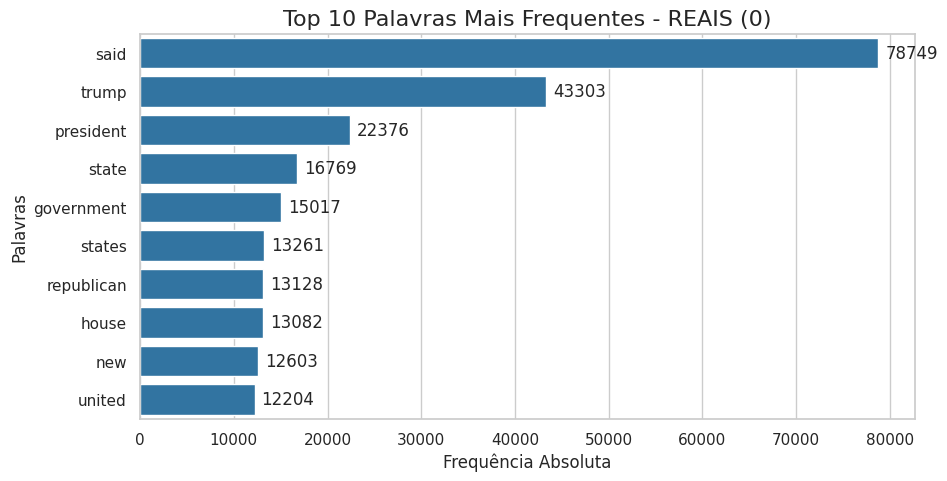

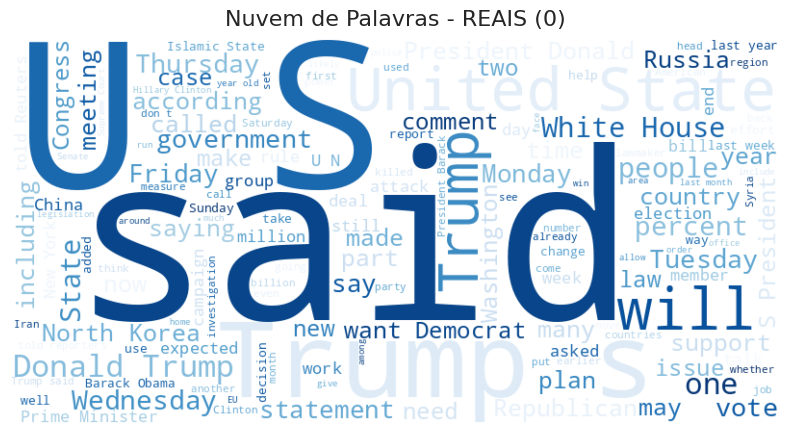


 VISUALIZAÇÕES: CLASSE 1 (NOTÍCIAS FALSAS)


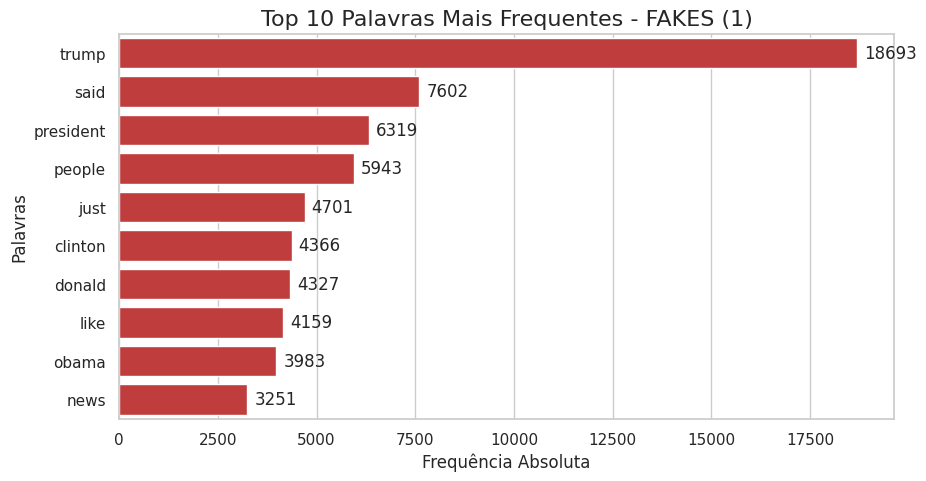

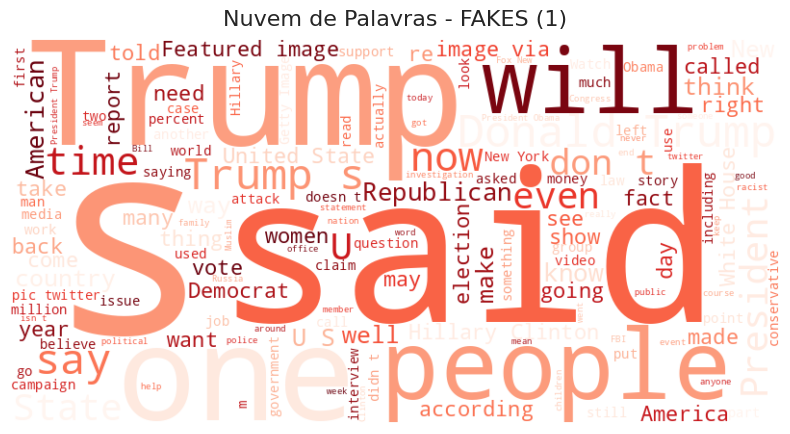

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# 4.1 Função para Nuvens de Palavras
def plot_wordcloud(text_series, title, colormap):
    text = " ".join(word for word in text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap=colormap, max_words=150,
                          stopwords=None).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16, pad=10)
    plt.axis("off")
    plt.show()

# 4.2 Função para o Histograma das Top 10 Palavras
def plot_top_words(text_series, title, color):
    # Usando stop_words='english' para ignorar 'the', 'is', 'and', etc.
    vec = CountVectorizer(stop_words='english', max_features=10).fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)

    # Criando uma lista de tuplas (palavra, frequencia)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Separando para o plot
    words = [x[0] for x in words_freq]
    counts = [x[1] for x in words_freq]

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=counts, y=words, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel("Frequência Absoluta", fontsize=12)
    plt.ylabel("Palavras", fontsize=12)

    # Adicionando os valores nas barras
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_width())}',
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points')
    plt.show()

# --- Execução das Visualizações ---

print("="*60)
print(" VISUALIZAÇÕES: CLASSE 0 (NOTÍCIAS REAIS)")
print("="*60)
plot_top_words(df[df['label'] == 0]['text_clean'], 'Top 10 Palavras Mais Frequentes - REAIS (0)', '#1f77b4')
plot_wordcloud(df[df['label'] == 0]['text_clean'], 'Nuvem de Palavras - REAIS (0)', 'Blues')

print("\n" + "="*60)
print(" VISUALIZAÇÕES: CLASSE 1 (NOTÍCIAS FALSAS)")
print("="*60)
plot_top_words(df[df['label'] == 1]['text_clean'], 'Top 10 Palavras Mais Frequentes - FAKES (1)', '#d62728')
plot_wordcloud(df[df['label'] == 1]['text_clean'], 'Nuvem de Palavras - FAKES (1)', 'Reds')

### 5. Engenharia de Features: Análise do Tamanho do Texto (Tokens)
Modelos baseados na arquitetura Transformer (BERT/RoBERTa) possuem uma limitação intrínseca de `max_length` para o input, tipicamente de 512 tokens. Textos maiores que isso precisam ser truncados (cortados).

Vamos calcular o número de palavras por notícia para definir qual será a nossa estratégia de `max_length` no momento da tokenização (ex: 256 vs 512).

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,16990.0,383.437198,274.095270,19.0,148.0,358.0,521.0,5170.0
1,5203.0,434.765328,415.661691,1.0,262.0,369.0,510.0,8135.0


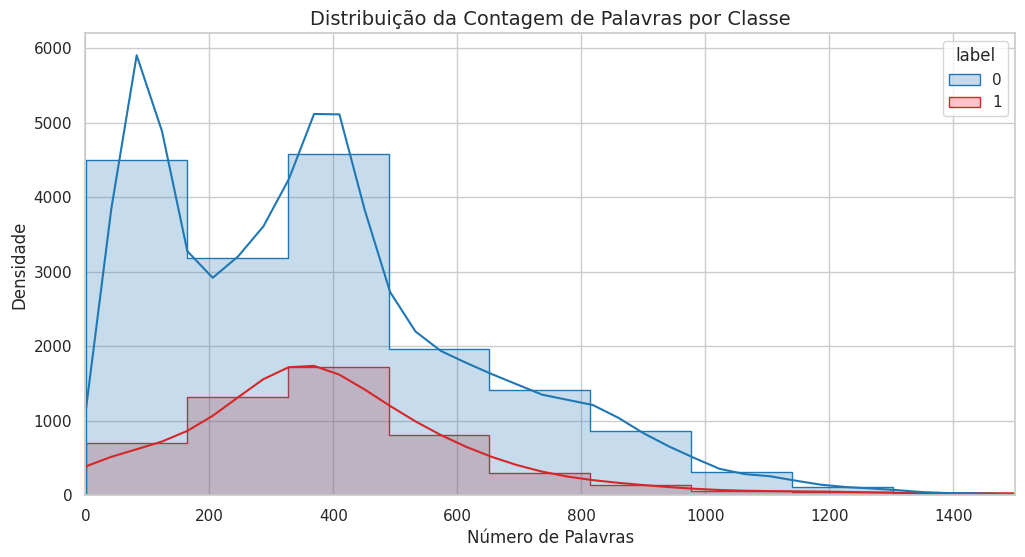

Textos com <= 512 palavras: 74.52% do dataset
Textos com <= 256 palavras: 33.29% do dataset


In [14]:
# Calculando o número de palavras por texto
df['word_count'] = df['text_clean'].apply(lambda x: len(str(x).split()))

# Estatísticas descritivas
display(df.groupby('label')['word_count'].describe())

# Distribuição do tamanho do texto
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', bins=50, kde=True, element="step", palette=['#1f77b4', '#d62728'])
plt.title('Distribuição da Contagem de Palavras por Classe')
plt.xlabel('Número de Palavras')
plt.ylabel('Densidade')
plt.xlim(0, 1500) # Limitando o eixo X para melhor visualização dos outliers
plt.show()

# Análise de Percentil
pct_512 = (df['word_count'] <= 512).mean() * 100
pct_256 = (df['word_count'] <= 256).mean() * 100
print(f"Textos com <= 512 palavras: {pct_512:.2f}% do dataset")
print(f"Textos com <= 256 palavras: {pct_256:.2f}% do dataset")

**Conclusão sobre o Tamanho do Texto:**
A grande maioria dos textos possui um tamanho adequado, mas existe uma proporção considerável que excede 256 e até 512 palavras.
* **Diretriz de Tokenização:** Utilizaremos `max_length = 512` no tokenizer do Transformer. Notícias costumam conter as informações mais relevantes no "Lead" (primeiros parágrafos). O truncamento padrão do Transformer (cortar o final e manter o início) será a estratégia ideal para os textos maiores.

### 6. Estruturação do Dataset Final e Salvamento
Removeremos todas as colunas desnecessárias. Além do `subject`, removeremos o `id` e a coluna `date` (modelos semânticos não devem aprender padrões em séries temporais específicas para identificar fake news, a menos que o foco seja modelagem temporal/contextual histórica).

In [15]:
# Preparando o dataframe final
df_final = df[['title', 'text_clean', 'label']].copy()

# O título da notícia é muito poderoso, vamos concatená-lo com o texto para maximizar a entrada de dados do modelo
df_final['input_text'] = df_final['title'] + " - " + df_final['text_clean']

# Dropando linhas que por ventura possam ter ficado vazias após a limpeza e reorganizando índices
df_final = df_final.dropna(subset=['input_text']).reset_index(drop=True)

# Mantendo apenas o essencial
df_final = df_final[['input_text', 'label']]

print("--- Formato do Dataset Pronto para Treinamento ---")
display(df_final.head())

--- Formato do Dataset Pronto para Treinamento ---


,input_text,label
0,"Exclusive: Pentagon, Lockheed near deal on $9 ...",0
1,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,1
2,Philippine leader says 'no way' he'll do deal ...,0
3,Biden asks U.S. Congress to allow unencumbered...,0
4,Trump Claims ‘Any Negative Polls’ Are ‘FAKE N...,1


#### 6.1 Integração com Google Drive
Abaixo, conectamos ao seu Google Drive e exportamos o `.csv` definitivo.

In [16]:
# Montar o Google Drive
drive.mount('/content/drive')

# Definir o caminho da pasta onde o projeto está sendo salvo (Ajuste o caminho conforme sua organização)
caminho_pasta = '/content/drive/MyDrive/PS_Ligia_NLP'

if not os.path.exists(caminho_pasta):
    os.makedirs(caminho_pasta)

# Salvar o arquivo
caminho_arquivo = os.path.join(caminho_pasta, 'ligia_dataset_processado.csv')
df_final.to_csv(caminho_arquivo, index=False)

print(f"✅ Dataset perfeitamente processado e salvo em: {caminho_arquivo}")

Mounted at /content/drive
✅ Dataset perfeitamente processado e salvo em: /content/drive/MyDrive/PS_Ligia_NLP/ligia_dataset_processado.csv


### 🎯 Considerações Técnicas para a Próxima Etapa (Modelagem)
Nossa EDA revelou os requisitos exatos para garantirmos um treinamento de modelo de ponta e sem vieses ocultos:
1. **Arquitetura Base:** Um modelo da família Transformer (`DistilBERT` para rapidez ou `RoBERTa` para acurácia semântica apurada).
2. **Features Utilizadas:** Apenas a junção estruturada de `Title + Text` (coluna `input_text`). O `subject`, `id`, `date`, valores nulos e marcações da agência `Reuters` foram removidos.
3. **Métricas a Monitorar:** Em virtude do forte desbalanceamento (Classe 0 dominante), confiaremos em **F1-Score (Macro)** e na curva ROC, fugindo da ilusão ótica da "Acurácia".
4. **Otimização da Função de Perda:** Passaremos tensores de `class_weights` para a `CrossEntropyLoss` nativa do PyTorch/HuggingFace no momento do Fine-Tuning.